In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
!pip install yfinance
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 24.4 MB/s eta 0:00:00
  Installing build dependencies ... - \ | / - done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.5/73.5 kB 3.1 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.6-cp310-cp310-linux_x86_64.whl size=293634 sha256=9ef68731f7ecc6995010665bf28eb0f8858d39a0b40f1d4da7782ed4f15193d3
  Stored in directory: /root/.cache/pip/wheels/4b/b9/b0/83d6e258e8f963f5ff111a2cd8c483ca59372a86e6a2535212
Successfully built peewee


Data Loading and Preprocessing

In [3]:
# Download stocks data
tickers = [
    "WIPRO.NS",
    "TATAMOTORS.NS",
    "HDFCBANK.NS",
    "INFY.NS",
    "JSWSTEEL.NS",
    "NTPC.NS",
    "LT.NS"
]


df = yf.download(tickers, start='2009-01-01', end=datetime.now().strftime('%Y-%m-%d'))['Adj Close']
df.head()

[*********************100%%**********************]  7 of 7 completed


Ticker,HDFCBANK.NS,INFY.NS,JSWSTEEL.NS,LT.NS,NTPC.NS,TATAMOTORS.NS,WIPRO.NS
Date,,,,,,,
2009-01-02,89.876762,102.294739,19.407169,295.196167,86.937737,31.959135,47.412209
2009-01-05,92.394356,105.972328,20.107740,306.623474,85.356201,32.394810,47.811043
2009-01-06,97.376434,105.588310,20.677214,304.084045,83.585823,33.847084,47.217659
2009-01-07,89.310417,107.305130,19.546465,277.062714,80.942047,31.614212,47.597046
2009-01-09,90.040459,108.737320,18.362446,257.820496,84.152351,30.089325,48.822712


EDA

In [4]:
df.shape

(3825, 7)

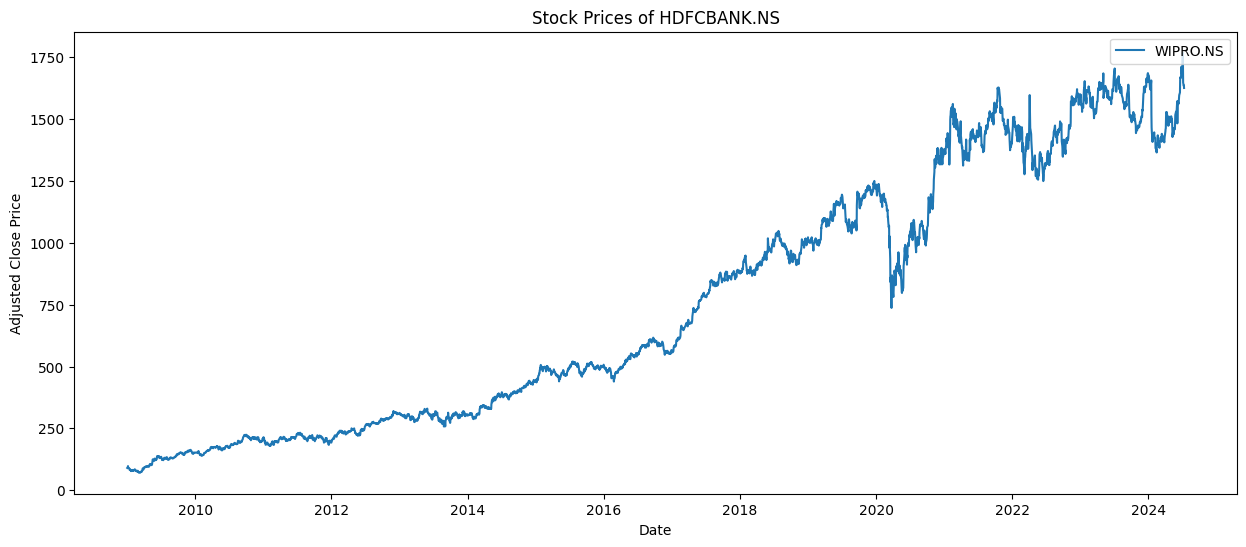

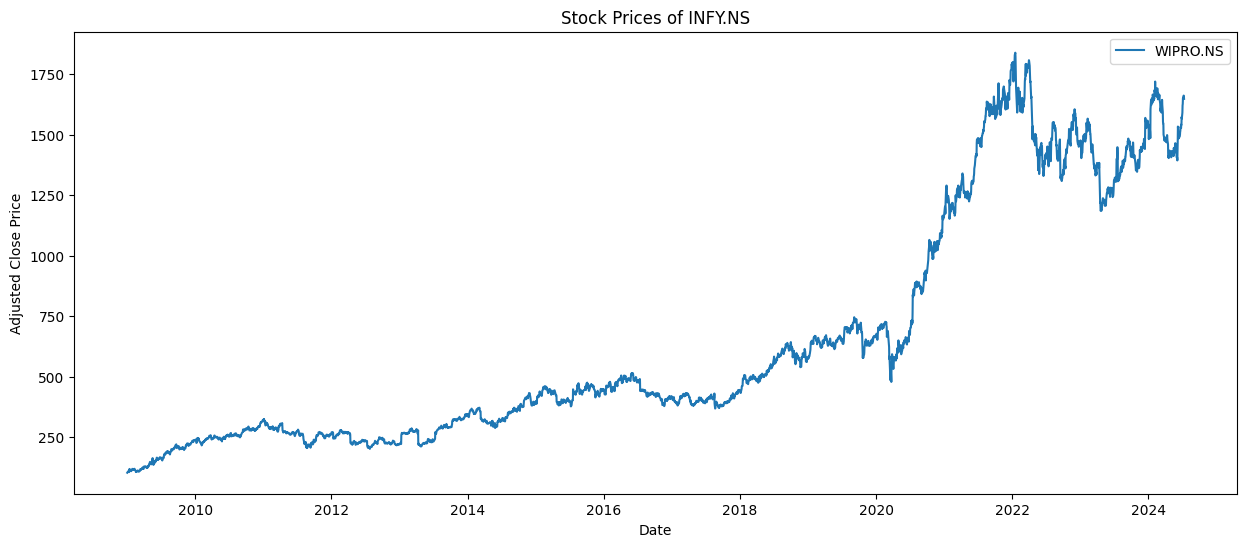

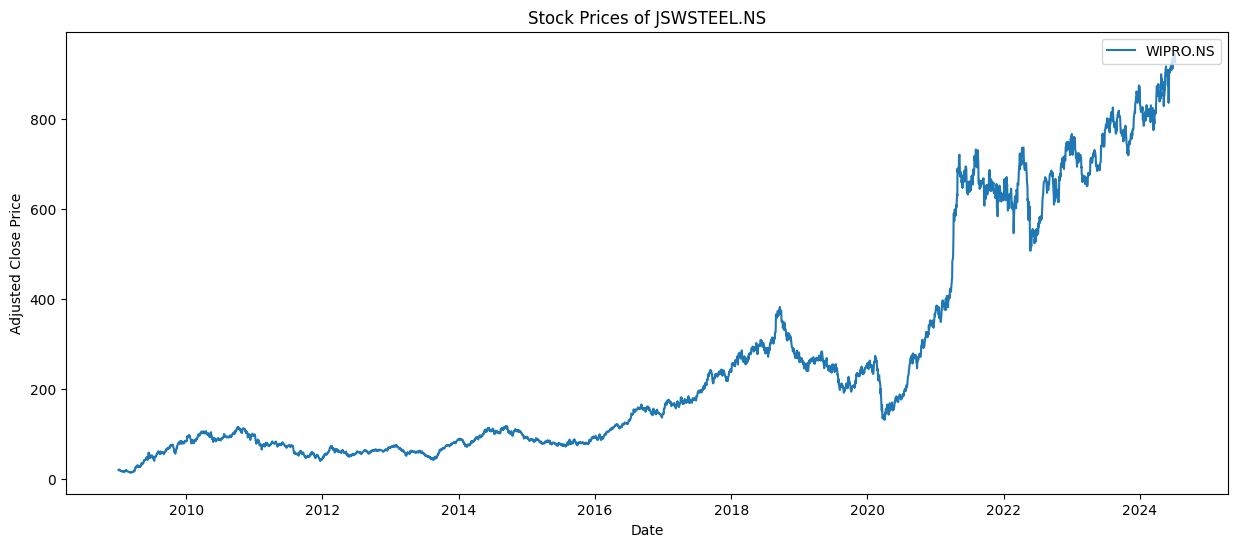

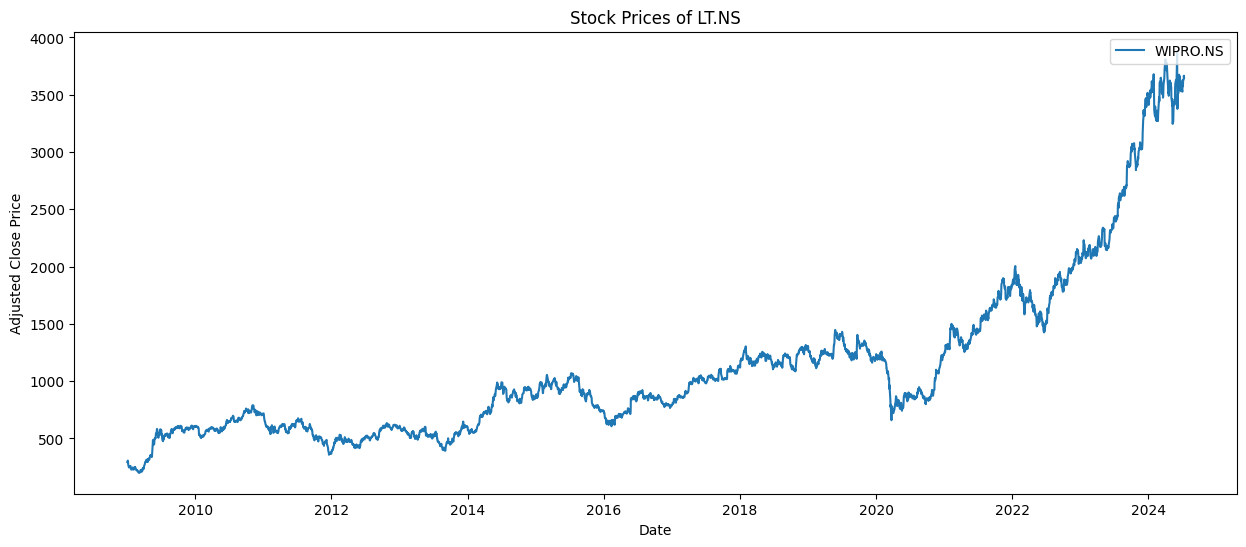

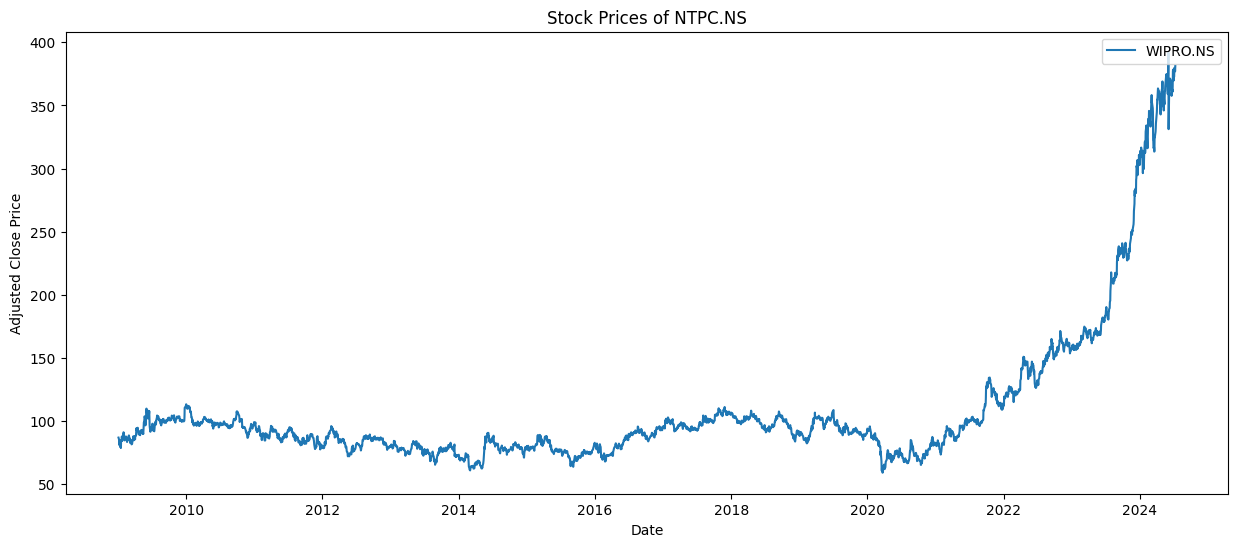

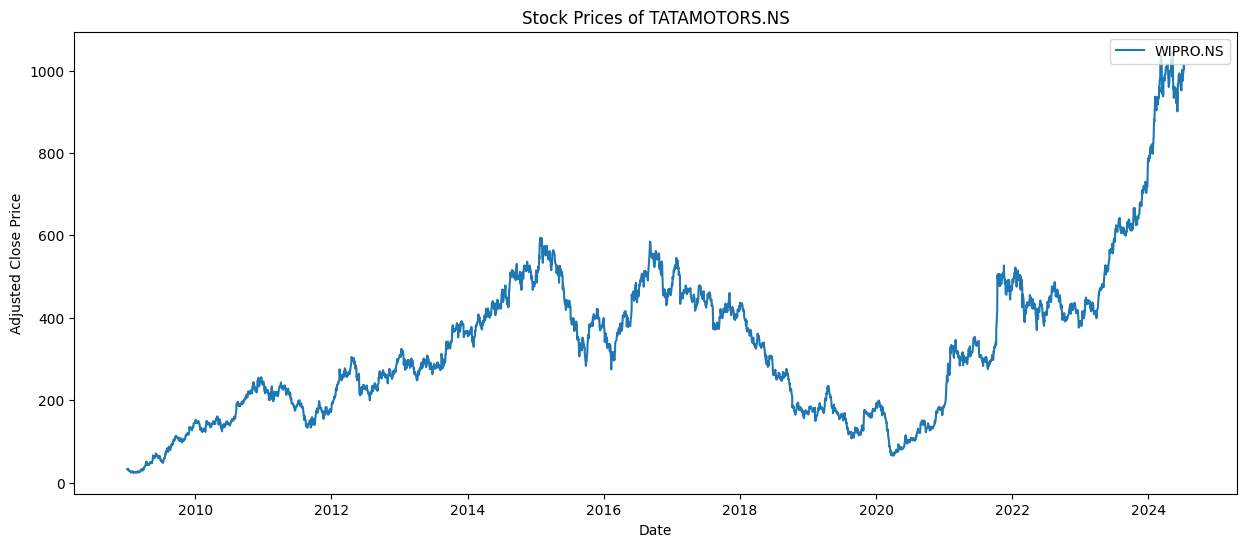

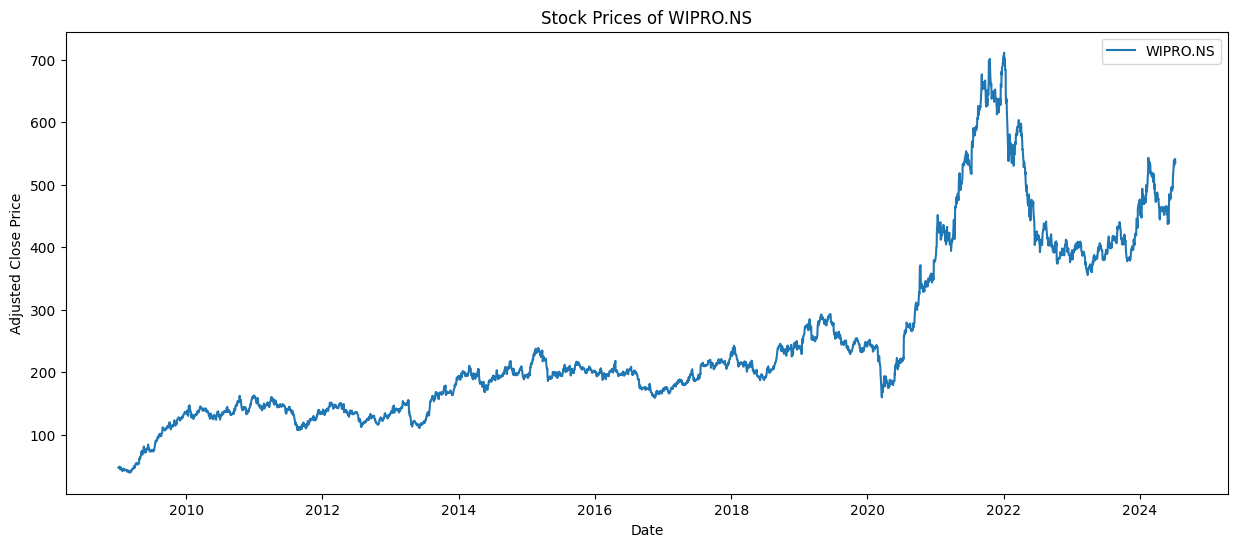

In [5]:
# Visualize stock prices
for i in df.columns:
    plt.figure(figsize=(15, 6))
    plt.plot(df[i])
    plt.title(f'Stock Prices of {i}')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price')
    plt.legend(tickers, loc='upper right', ncol=2)

Text(0.5, 1.0, 'Correlation Matrix of NIFTY 50 Stocks')

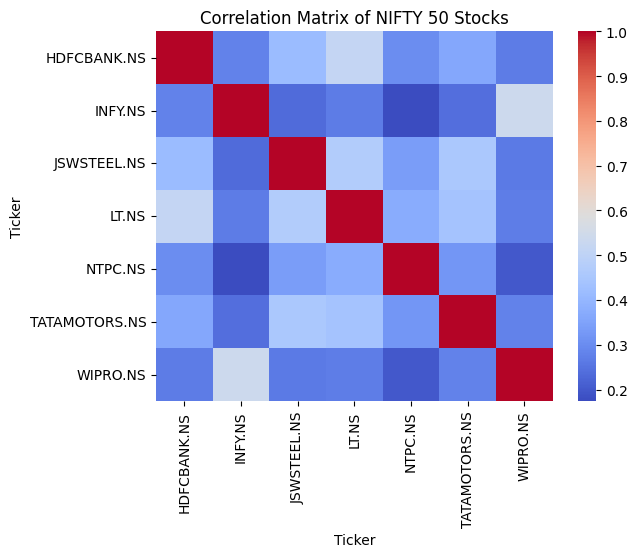

In [6]:
# Calculate daily returns
returns = df.pct_change().dropna()

# Plot the correlation matrix
sns.heatmap(returns.corr(), cmap='coolwarm', annot=False)
plt.title('Correlation Matrix of NIFTY 50 Stocks')
# plt.show()

Optimization

In [7]:
# Calculate daily returns
returns = df.pct_change().dropna()

# Calculate annualized returns
annual_returns = returns.mean() * 252
cov_matrix = returns.cov() * 252

In [8]:
# Define portfolio optimization function
def portfolio_optimization(returns, cov_matrix, risk_free_rate=0.05):
    num_assets = len(returns)

    # Objective function: minimize negative Sharpe ratio
    def objective(weights):
        portfolio_return = np.dot(weights, returns)
        portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
        return -sharpe_ratio

    # Constraints: weights sum to 1, and all weights are non-negative
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Initial guess: equal weights
    initial_weights = num_assets * [1. / num_assets, ]

    # Perform optimization
    result = minimize(objective, initial_weights, bounds=bounds, constraints=constraints)
    return result

In [9]:
from scipy.optimize import minimize
# Perform portfolio optimization
opt_result = portfolio_optimization(annual_returns, cov_matrix)

# Extract optimal weights
optimal_weights = opt_result.x

# Display optimal weights
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {100*weight:.2f}%")

WIPRO.NS: 32.21%
TATAMOTORS.NS: 25.94%
HDFCBANK.NS: 19.89%
INFY.NS: 0.00%
JSWSTEEL.NS: 0.00%
NTPC.NS: 12.35%
LT.NS: 9.61%


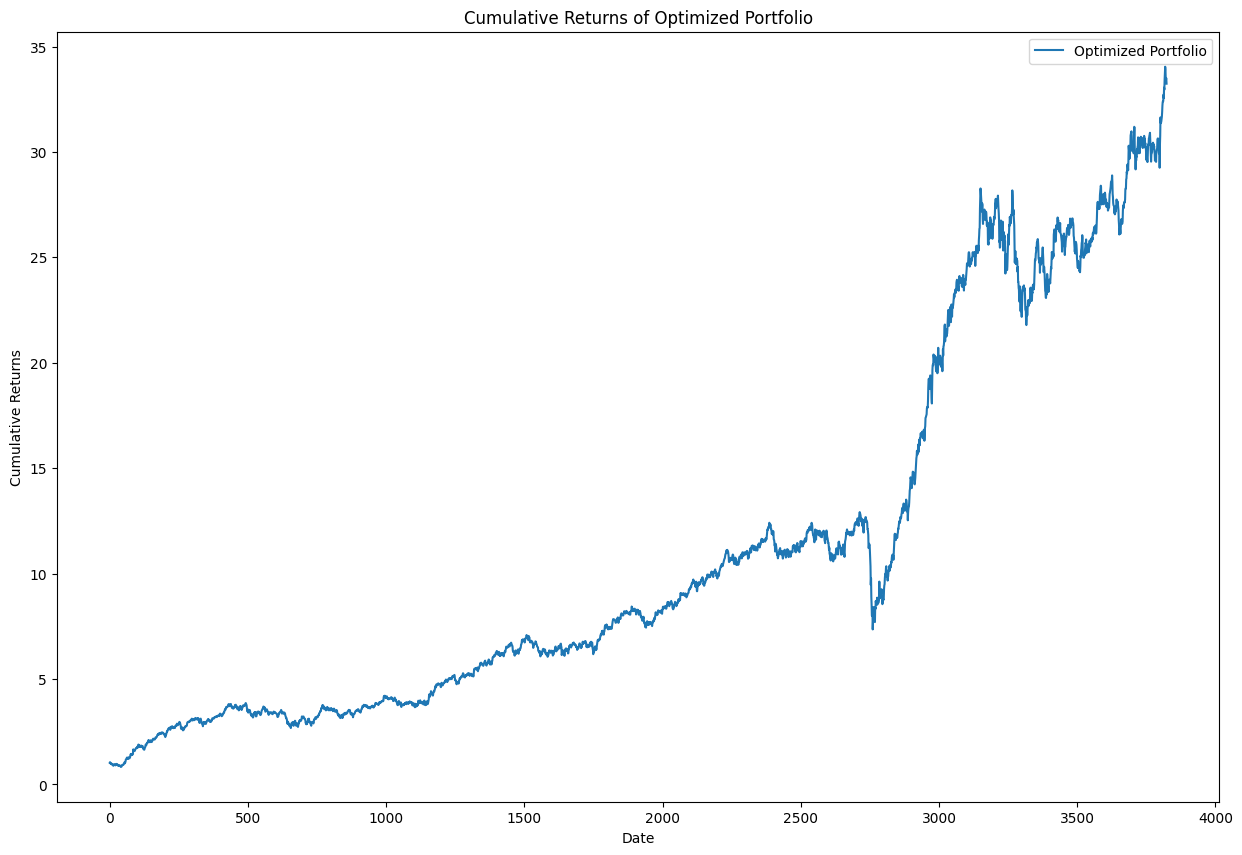

Mean Annual Return: 0.25
Annual Volatility: 0.22
Sharpe Ratio: 1.18


In [10]:
# Calculate portfolio returns
portfolio_returns = np.dot(returns, optimal_weights)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Plot cumulative returns
plt.figure(figsize=(15, 10))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Cumulative Returns of Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()

# Summary statistics
mean_return = np.mean(portfolio_returns) * 252
volatility = np.std(portfolio_returns) * np.sqrt(252)
sharpe_ratio = mean_return / volatility

print(f"Mean Annual Return: {mean_return:.2f}")
print(f"Annual Volatility: {volatility:.2f}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
